In [1]:
import numpy as np
import pandas as pd
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def unpickle(filepath):
    import pickle
    return pickle.load(open(filepath, 'rb'))    

In [3]:
PATH_100 = "./data/cifar-100-python/meta"
PATH_10 = "./data/cifar-10-batches-py/batches.meta"

In [4]:
def class_extractor(dataset):
    if dataset == 'CIFAR10':
        dict_classes = unpickle(PATH_10)
        return tuple(dict_classes['label_names'])
    else:
        dict_classes = unpickle(PATH_100)
        return tuple(dict_classes['fine_label_names'])

In [5]:
save = True
train = True
batch_size = 128
n_epochs = 164
dataset = 'CIFAR100'

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_load_set_args = {'root':'./data', 'train':True, 'download':True, 'transform':transform}
test_load_set_args = {'root':'./data', 'train':False, 'download':True, 'transform':transform}
if dataset == 'CIFAR10':
    trainset = torchvision.datasets.CIFAR10(**train_load_set_args)
    testset = torchvision.datasets.CIFAR10(**test_load_set_args)
else:
    trainset = torchvision.datasets.CIFAR100(**train_load_set_args)
    testset = torchvision.datasets.CIFAR100(**test_load_set_args)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = class_extractor(dataset)
n_classes = len(classes)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
len(trainset.train_labels)
trainset.

50000

In [7]:
class CNN_vanilla(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
net = CNN_vanilla().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
if train:
    for epoch in range(n_epochs):    
        avg_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            avg_loss += (loss.item() - avg_loss)/(i+1)
            print('[%d, %3d] loss: %.3f' % (epoch + 1, i + 1, avg_loss), end="\r")            
        print('')
    print('Finished Training')

[1, 391] loss: 4.606
[2, 391] loss: 4.605
[3, 391] loss: 4.605
[4, 391] loss: 4.604
[5, 391] loss: 4.603
[6, 391] loss: 4.602
[7, 391] loss: 4.599
[8, 391] loss: 4.590
[9, 391] loss: 4.550
[10, 391] loss: 4.430
[11, 391] loss: 4.295
[12, 391] loss: 4.182
[13, 391] loss: 4.019
[14, 391] loss: 3.894
[15, 391] loss: 3.823
[16, 391] loss: 3.763
[17, 391] loss: 3.708
[18, 391] loss: 3.652
[19, 391] loss: 3.602
[20, 391] loss: 3.554
[21, 391] loss: 3.510
[22, 391] loss: 3.463
[23, 391] loss: 3.422
[24, 391] loss: 3.379
[25, 391] loss: 3.333
[26, 391] loss: 3.291
[27, 391] loss: 3.249
[28, 391] loss: 3.210
[29, 391] loss: 3.170
[30, 391] loss: 3.133
[31, 391] loss: 3.099
[32, 391] loss: 3.064
[33, 391] loss: 3.027
[34, 391] loss: 2.996
[35, 391] loss: 2.971
[36, 391] loss: 2.936


KeyboardInterrupt: 

In [10]:
if save:
    torch.save(net.state_dict(), './nets/'+dataset+'_net.pth')
else:
    net = CNN_vanilla().to(device)
    net.load_state_dict(torch.load('./nets/'+dataset+'_net.pth'))

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 25 %


In [12]:
n = len(classes)
class_correct = list(0. for i in range(n))
class_total = list(0. for i in range(n))
confusion_matrix = np.zeros([n,n]).astype(int)
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            prediction = predicted[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            confusion_matrix[label, prediction] += 1

for i in range(n):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / max(class_total[i],1)))

Accuracy of apple : 52 %
Accuracy of aquarium_fish : 33 %
Accuracy of  baby :  5 %
Accuracy of  bear : 10 %
Accuracy of beaver : 16 %
Accuracy of   bed : 29 %
Accuracy of   bee : 23 %
Accuracy of beetle : 15 %
Accuracy of bicycle : 24 %
Accuracy of bottle : 28 %
Accuracy of  bowl :  4 %
Accuracy of   boy : 11 %
Accuracy of bridge : 10 %
Accuracy of   bus : 10 %
Accuracy of butterfly : 29 %
Accuracy of camel : 11 %
Accuracy of   can : 32 %
Accuracy of castle : 50 %
Accuracy of caterpillar : 13 %
Accuracy of cattle : 28 %
Accuracy of chair : 57 %
Accuracy of chimpanzee : 56 %
Accuracy of clock : 27 %
Accuracy of cloud : 47 %
Accuracy of cockroach : 47 %
Accuracy of couch :  5 %
Accuracy of  crab : 12 %
Accuracy of crocodile : 15 %
Accuracy of   cup : 38 %
Accuracy of dinosaur : 14 %
Accuracy of dolphin : 33 %
Accuracy of elephant : 16 %
Accuracy of flatfish : 20 %
Accuracy of forest : 25 %
Accuracy of   fox :  4 %
Accuracy of  girl : 24 %
Accuracy of hamster : 25 %
Accuracy of house : 18

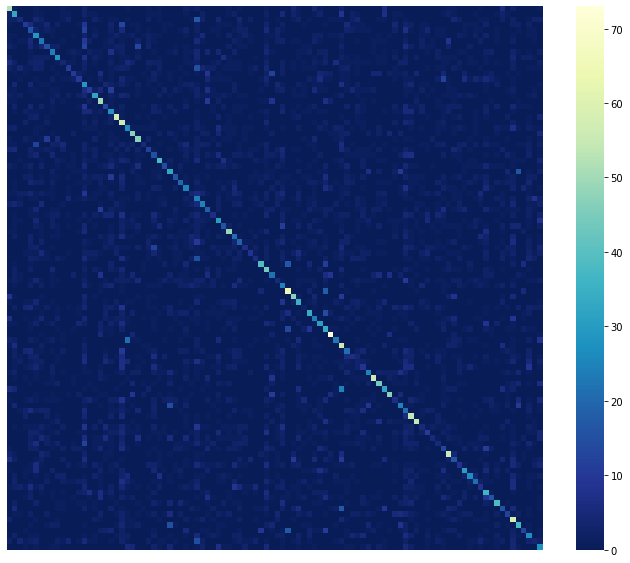

In [25]:
fig, ax = plt.subplots(figsize=(12,10))

confusion_df = pd.DataFrame(data=confusion_matrix, index=classes,
                           columns=classes)
if dataset == 'CIFAR10':
    hm = sns.heatmap(confusion_df, cmap="YlGnBu_r",
                annot=True, fmt="d", linewidths=0.1, cbar=False)
    hm.set_yticklabels(hm.get_yticklabels(), rotation = 0)
else:
    hm = sns.heatmap(confusion_matrix, cmap="YlGnBu_r",
                    annot=False, fmt="d", linewidths=0, cbar=True,
                    xticklabels=False, yticklabels=False)
plt.show()